In [126]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import vector_tools as vt
import Plot_tools as pt

# Data 
The study consisted of deploying a mooring within the Stillwater Kelp forest from July 22nd to September 8th:
- Central mooring was dropped at a location with approximately 10 meters of continuous kelp coverage in all directions
    - 36.56196, -121.94176
- Maximum water depth was 38ft (11.6m), with an average of 34ft (10.4m)
- HOBO temperature logger pro V2's attached to a taut line suspended by subsurface buoy at the mooring weight
    - 7/21/2022 - 9/8/2022
    - 36.56196, -121.94176 (same as central mooring weight
    - Loggers placed along the line at 9.7, 9.4, 9.1, 8, 6, 4, and 2 meters below the surface
    - Each logger sampled continuously at 1 minute intervals
- Teledyne RDI ADCP platform placed within relatively clear sand patch within the forest 
    - First deployment
        - 7/21/2022 - 8/14/2022
        - 36.56194210195769, -121.94175918358738
        - Sampled continuously, 1-minute long ensembles averaging 70 pings/minute
        - Bins start at 1m off bottom with .25m spacing between them
    - Second deployment
        - 8/23/2022 - 8/30/2022
        - 36.56194989498659, -121.9417662787946
        - Sampled for 20 minute bursts every hour at 1Hz averaging 12 subpings/second (mode 12)
- Nortek Vector ADV placed in tripod on the seafloor near kelp clusters, velocity transducers were 1m off the floor
    - Sampled for 20 minute bursts every hour at 32Hz
    - 36.56195999999164, -121.94174126537672 (wasn't moved during retrieval and redeployment)
    - First deployment
        - 8/2/2022 - 8/11/2022
    - Second deployment
        - 8/15/2022 - 8/30/2022  
- Monterey Bay Aquarium Research Institute M1 Mooring data (7/21/2022 - 9/9/2022)
- NOAA National Buoy Data Center Statino 46042 (July - September)
- Radial kelp surveys conducted via SCUBA 
    - Each survey consisted of 8 4m x 10m transects run at 0, 45, 90, 135, 180, 225, 270, 315 degree headings
    - Each individual "stipe bundle" within the 4m diameter had its distance and heading on the transect, as well as its diameter recorded
    - A "stipe bundle" is subjectively defined as a any tightly spaced cluster of stipes
        - This sometimes includes multiple kelp individuals that have grown so close together that they are indistinguishable from a single shape

### Import data

In [112]:
# Temperature data
temp = xr.open_dataset('Temperature/temp_final.nc')

# ADCP data
adcp1 = xr.open_dataset('ADCP/adcp1_qc.nc')
adcp2 = xr.open_dataset('ADCP/adcp2_qc.nc')

# ADV data
adv1 = xr.open_dataset('ADV/adv1IntAvg.nc')
adv2 = xr.open_dataset('ADV/adv2IntAvg.nc')

# M1 data
m1_ns = xr.open_dataset('M1/m1_ns.nc')
m1_ew = xr.open_dataset('M1/m1_ew.nc')
m1_temp = xr.open_dataset('M1/m1_temp.nc')
m1_wind = xr.open_dataset('M1/m1_wind.nc')

# NBDC 46042 data
nbdc_july = xr.open_dataset('46042_Buoy/nbdc_july.nc')
nbdc_aug = xr.open_dataset('46042_Buoy/nbdc_aug.nc')
nbdc_sept = xr.open_dataset('46042_Buoy/nbdc_sept.nc')

# Kelp survey data

# Description of Stillwater Cove and Kelp Forest Site
Stillwater Cove (SWC) is a small inlet located at Northern tip of Carmel Bay between Pescadero Point and Arrowhead point. SWC is directly east of Pebble beach, and the two beaches are seperated by a shallow-water, south-running ridge that culminates in a protruding spire of rocks at the offshore boundary known as the Pescadero Rocks. Pesacdero Point, Arrowhead Point, and the Pescadero Rocks all shield SWC from the typical Northwesterly winds that Monterey Bay experiences, but not Westerly or Southerly winds. This means that while the site is generally protected from larger swell events coming from the North, it may still be affected. SWC experiences a mixed semidiurnal tidal cycle, and may also receive injections of cold water from offshore
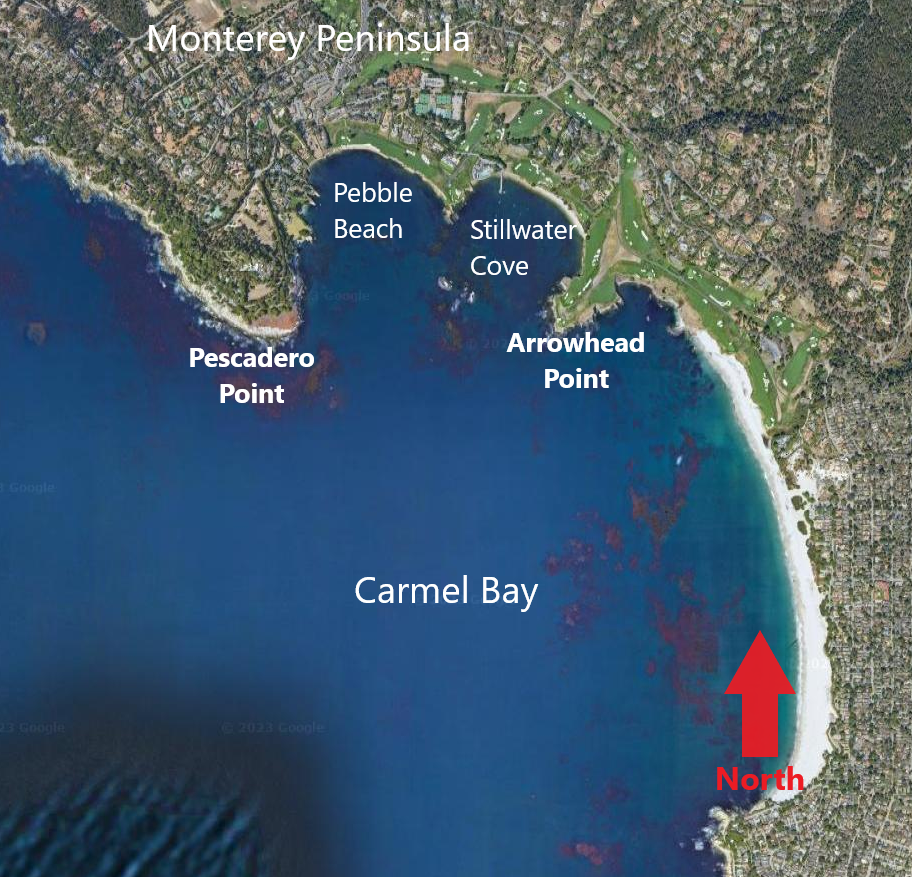
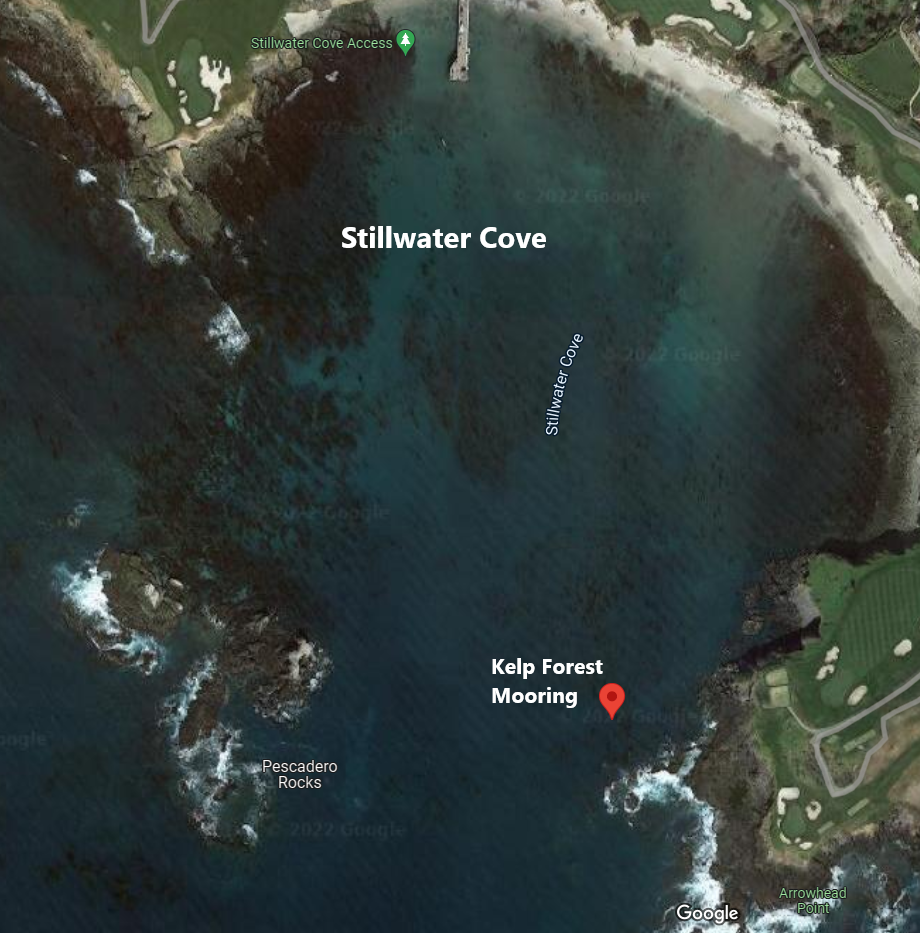

Subsampling
Resampling
Plotting
Subsampling
Resampling
Plotting
Subsampling
Resampling
Plotting
Subsampling
Resampling
Plotting


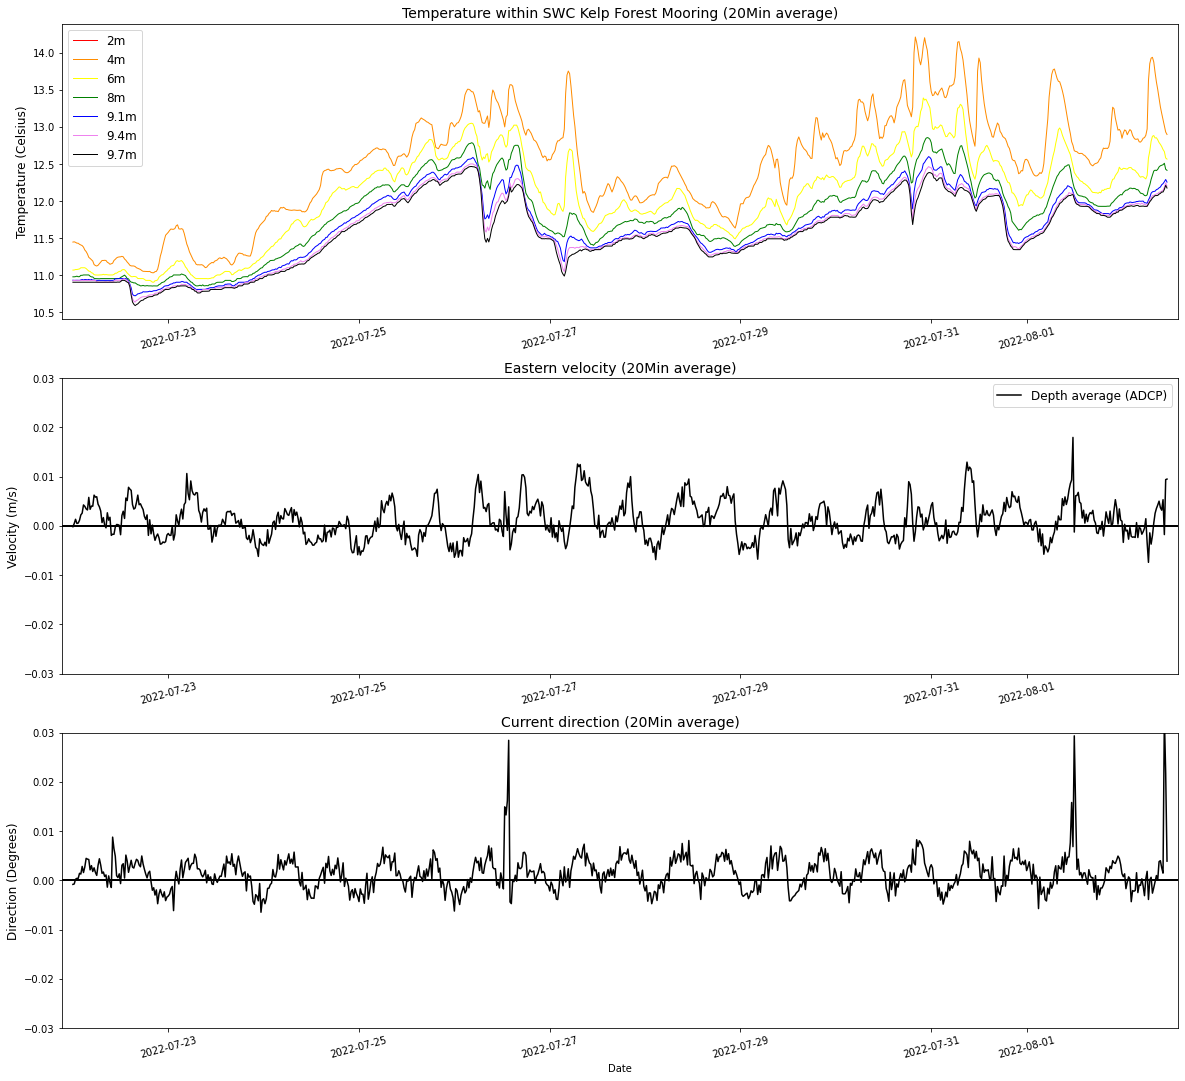

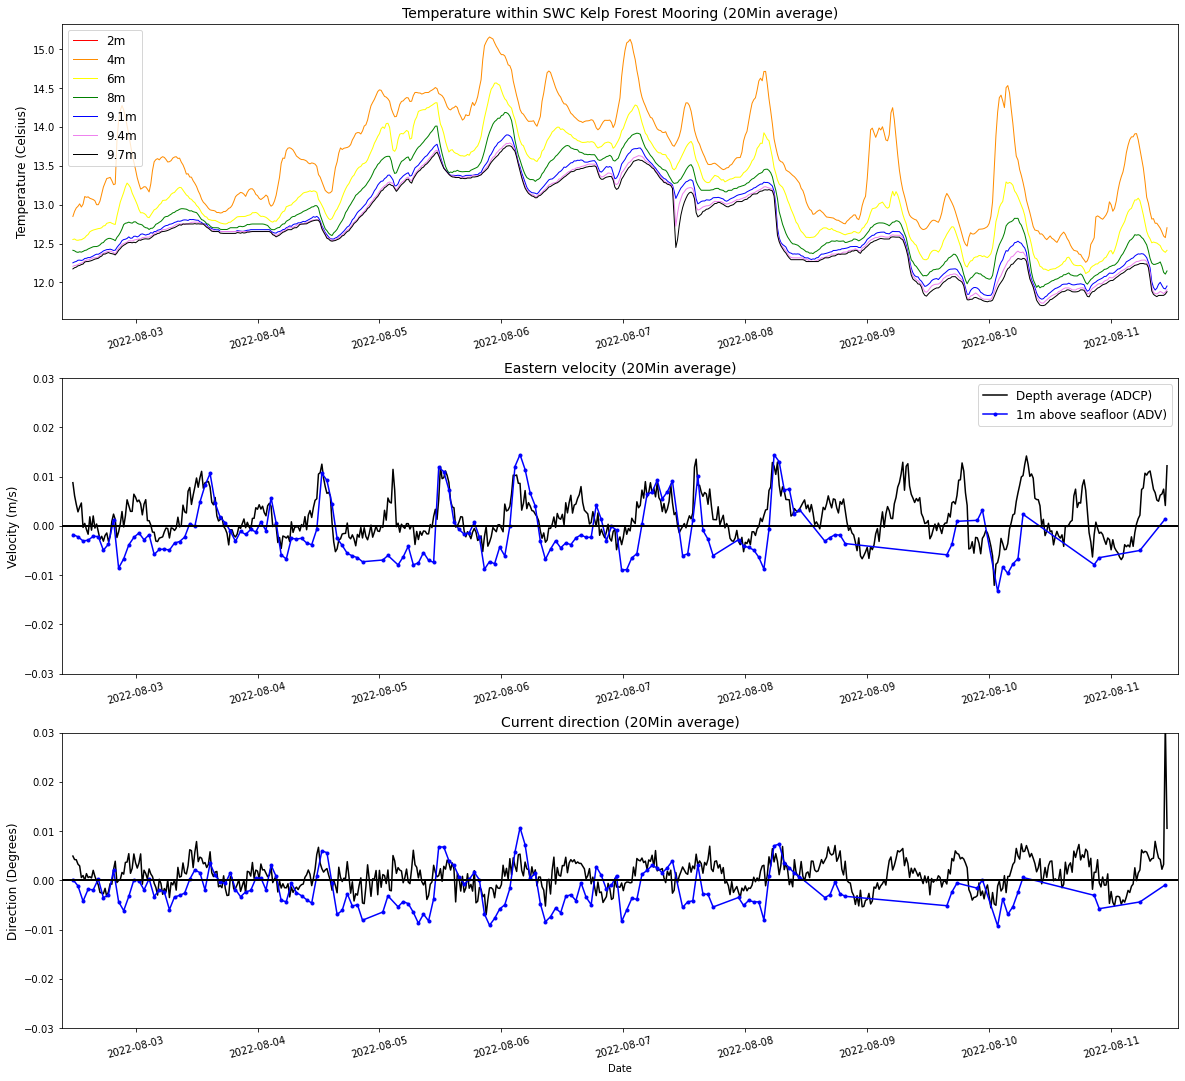

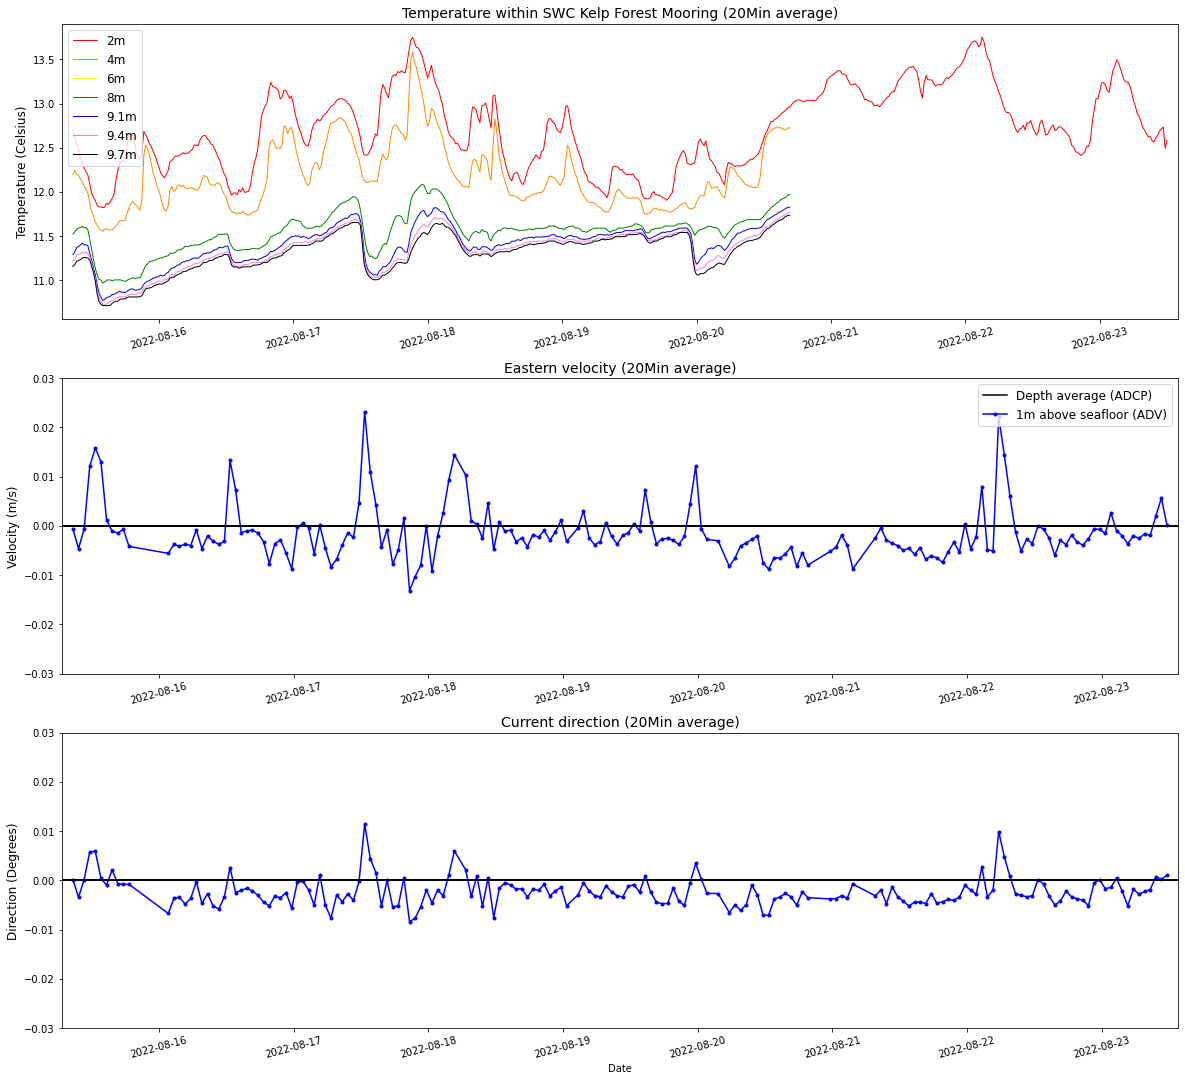

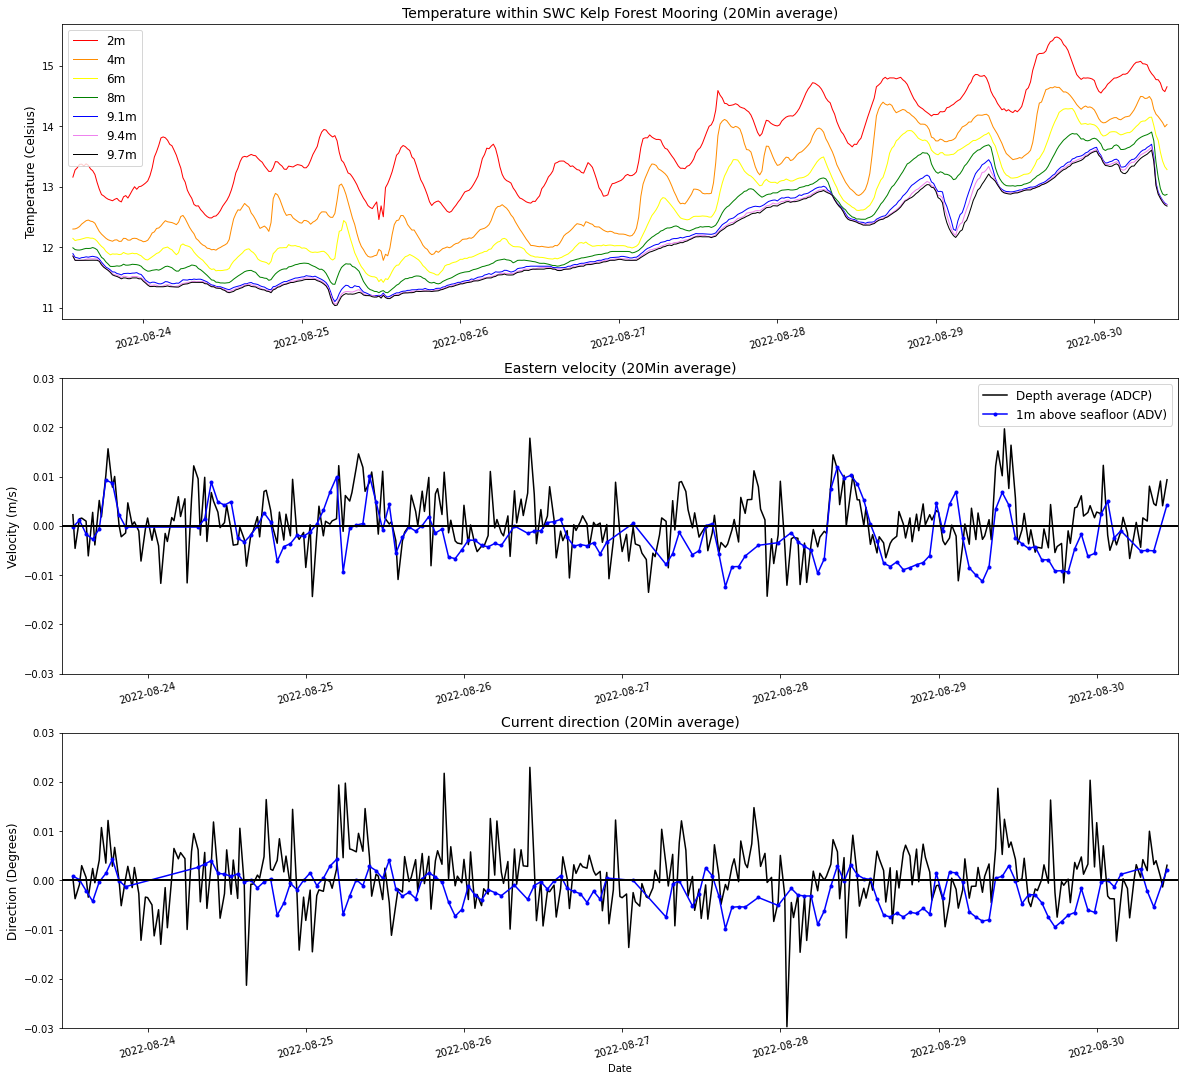

In [137]:
#Plot temperature profile with currents speeds from ADCP and ADV over each of the time series segments

#20-minute averaging interval smooths noise from the data while still resolving important cooling events
rsamp = '20Min'

#Segment 1 (Temperature and adcp data, no adv)
dep1TS = '2022-07-22T00:00:00.000000000' #Start time
dep1TE = '2022-08-02T11:39:00.000000000' #End time
pt.overview_plot(temp, adcp1, advData = None, startTime = dep1TS, endTime = dep1TE, resample = rsamp, saveFig = 'Plots/SWC_overview_0722_0802.png')

#Segment 2 (Temperature, adcp, and adv data)
dep2TS = '2022-08-02T11:40:00.000000000'
dep2TE = '2022-08-11T11:00:00.000000000'
pt.overview_plot(temp, adcp1, advData = adv1, startTime = dep2TS, endTime = dep2TE, resample = rsamp, saveFig = 'Plots/SWC_overview_0802_0811.png')

#Segment 3 (Temperature and adv data, no adcp)
dep3TS = '2022-08-15T08:40:00.000000000'
dep3TE = '2022-08-23T12:00:00.000000000'
pt.overview_plot(temp, adcp2, advData = adv2, startTime = dep3TS, endTime = dep3TE, resample = rsamp, saveFig = 'Plots/SWC_overview_0815_0823.png')

#Segment 4 (Temperature, adcp, and adv data)
dep4TS = '2022-08-23T12:40:00.000000000'
dep4TE = '2022-08-30T11:00:00.000000000'
pt.overview_plot(temp, adcp2, advData = adv2, startTime = dep4TS, endTime = dep4TE, resample = rsamp, saveFig = 'Plots/SWC_overview_0823_0830.png')

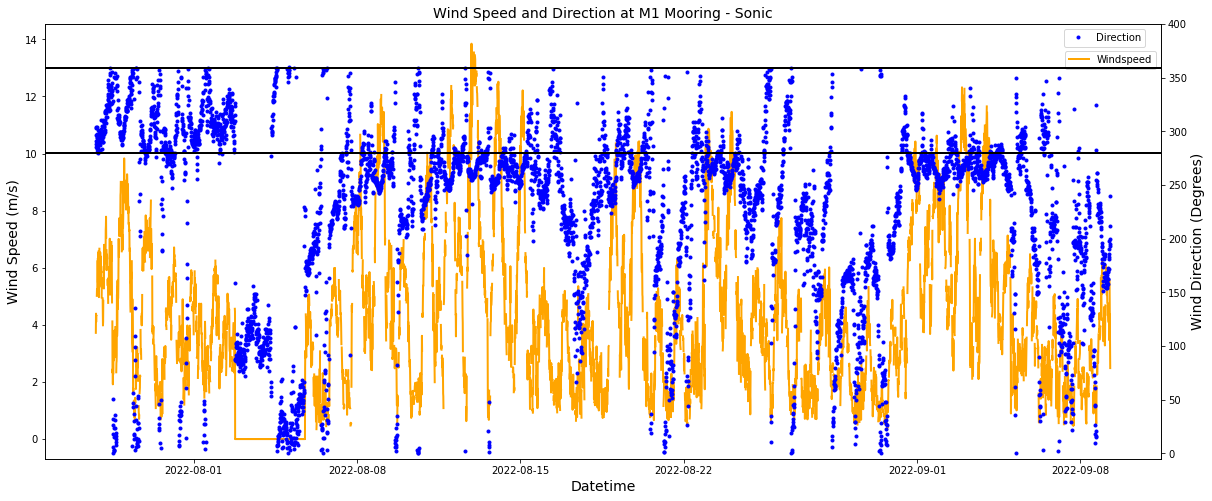

In [59]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (20, 8))

# make a plot

lns1 = ax.plot(m1_wind.time, m1_wind.wind_speed_sonic, 'orange', lw = 2, label='Windspeed')
# set x-axis label
ax.set_xlabel("Datetime", fontsize = 14)
# set y-axis label
ax.set_ylabel("Wind Speed (m/s)", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
lns2 = ax2.plot(m1_wind.time, m1_wind.wind_from_direction_sonic, '.b', lw = 2, label='Direction')
ax2.set_ylim(-5,400)
ax2.set_ylabel("Wind Direction (Degrees)",fontsize=14)


# Solution for having two legends
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax.legend(loc=1, bbox_to_anchor=(1,.95)) #(leg, labs, loc=0)
plt.axhline(y=359, c='black', lw=2)
plt.axhline(y=280, c='black', lw=2)
plt.title('Wind Speed and Direction at M1 Mooring - Sonic', fontsize=14)
plt.legend(bbox_to_anchor=(.99,1))

plt.margins(x=.01, y = .5)
#plt.show()
#plt.savefig('Plots/m1_windspeed_+_direction.PNG')

### Turbulent Kintetic Energy Dissipation Rate ($\epsilon$)
- Any velocity measurements with a Signal-to-noise ratio below 10 or a Correlation below 60% on any of the three beams is removed
- ADV data is despiked using an exanding ellipsoid algorithm outlined in Wheeler and Giddings (2023)
- The data gaps created by the quality control and despiking process are then linearly interpolated over gaps <= 1 second, with larger gaps being filled in with the average of the orginal values present within the gap
- These "fixed" data points are labelled as "unoriginal", and a ratio of unoriginal to original data points is recorded for future quality control
- $\epsilon$ is estimated from the vertical velocity spectra of 20-minute ADV bursts with an unoriginal ratio < 0.25
- Each burst was filtered using a Hann window with 60-second segments and 50% overlap resulting in 106 degrees of freedom (Thomson and Emery, 2014)
- Locating the inertial subrange (ISR):
    - Initial boundaries of the ISR were estimated as the peak surface wave frequency (low boundary) and the instrument noise floor (high boundary), which was consistently set at 3.5 Hz
    - To estimate the peak wave frequency, pressure spectra recorded by the ADV was converted to vertical velocity via linear wave theory
    - Within these boundaries, every sequence of points with a minimum range of 1Hz was fit with a power-law curve and a power-law with fixed -5/3 slope, both using least squares error
- Calculating $\epsilon$:
    - $\epsilon(\omega)$ = ${\langle\frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)}\rangle} ^\frac{3}{2}$
    - $S_{ww}(\omega)$ = Vertical velocity spectra at omega
    - $\omega$ = radian frequency being evaluated
    - $\alpha$ = 1.5 (Kolmogoroff's constant)
    - $J_{33}(\omega)$ = integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities
    - $\epsilon$ is estimated over all radian frequencies within proposed inertial subrange
- The $\epsilon$ estimates were then run through a series of quality control tests:
    - The intercept of the fit is > standard error in the intercept (Jones and Monosmith, 2008)
    - The average of the noise floor magnitude < half the magnitude of spectrum at lower ISR boundary (Gerbi et al. 2009)
    - The slope ($\mu$) and slope error($\mu_{err}$) of the fit fall within acceptable boundaries:
        - $\mu$ - 2$\mu_{err}$ - .06 < -5/3 < $\mu$ + 2$\mu_{err}$ + .06 (Feddersen, 2010)
        - $\frac{|\mu + \frac{5}{3}|}{\mu_{err}}$ < 1.960 (Wheeler and Giddings, 2023)
    - Linear regression of $\epsilon(\omega)$ over suggested ISR has a slope that is statiscally indistinguishable from 0
- From the suggested ISR ranges that pass all tests, the the fit with the lowest root mean square error from the -5/3 fit was chosen as the best
- From this best fit, the mean of $\epsilon$ over the ISR is calculated and used as the final value of $\epsilon$ for the data burst

In [ ]:
# Turbulent dissipation data
eps1 = xr.open_dataset('Dissipation/eps1Int_final.nc')
eps2 = xr.open_dataset('Dissipation/eps2Int_final.nc')